# Análisis Económico: Salarios e Inversión Extranjera Directa en México
## Estados: CDMX, Jalisco y Nuevo León (2010-2025)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
%matplotlib inline

## 1. Carga y Preparación de Datos

In [2]:
salarios_cdmx = pd.read_csv('salarios/salario_cdmx.csv')
salarios_jalisco = pd.read_csv('salarios/salario_jalisco.csv')
salarios_nl = pd.read_csv('salarios/salario_nl.csv')

ied_cdmx = pd.read_csv('ied/ied_cdmx.csv')
ied_jalisco = pd.read_csv('ied/ied_jalisco.csv')
ied_nl = pd.read_csv('ied/ied_nl.csv')

salarios = pd.concat([salarios_cdmx, salarios_jalisco, salarios_nl], ignore_index=True)
ied = pd.concat([ied_cdmx, ied_jalisco, ied_nl], ignore_index=True)

salarios['Year'] = salarios['Quarter'].str[:4].astype(int)
salarios['Q'] = salarios['Quarter'].str[-2:]
salarios['Date'] = pd.to_datetime(salarios['Time'], unit='ms')

ied['Year'] = ied['Year'].astype(str).str.strip().astype(int)
ied['Investment_B'] = ied['Investment (USD)'] / 1e9

print(f"Datos de salarios: {salarios.shape}")
print(f"Datos de IED: {ied.shape}")
salarios.head()

Datos de salarios: (180, 10)
Datos de IED: (78, 6)


,State ID,State,Quarter ID,Quarter,Monthly Wage,Workforce,Time,Year,Q,Date
0,9,Ciudad de México,20101,2010-Q1,4237.438903,3960254,1265004000000,2010,Q1,2010-02-01 06:00:00
1,9,Ciudad de México,20102,2010-Q2,4347.174149,3972700,1272690000000,2010,Q2,2010-05-01 05:00:00
2,9,Ciudad de México,20103,2010-Q3,4196.546097,4024348,1280638800000,2010,Q3,2010-08-01 05:00:00
3,9,Ciudad de México,20104,2010-Q4,3815.434041,3927011,1288591200000,2010,Q4,2010-11-01 06:00:00
4,9,Ciudad de México,20111,2011-Q1,3931.049038,3931449,1296540000000,2011,Q1,2011-02-01 06:00:00


## 2. Exploración de Datos

In [3]:
estadisticas_salarios = salarios.groupby('State').agg({
    'Monthly Wage': ['mean', 'min', 'max', 'std'],
    'Workforce': ['mean', 'min', 'max']
}).round(2)

estadisticas_ied = ied.groupby('State').agg({
    'Investment_B': ['sum', 'mean', 'max']
}).round(2)

print("\nEstadísticas de Salarios por Estado:")
print(estadisticas_salarios)
print("\nEstadísticas de IED por Estado (Miles de Millones USD):")
print(estadisticas_ied)


Estadísticas de Salarios por Estado:
                 Monthly Wage                              Workforce           \
                         mean      min      max      std        mean      min   
State                                                                           
Ciudad de México      4070.24  3081.01  6888.91   796.51  4242839.28  3407733   
Jalisco               4675.36  3355.27  6508.46   880.88  3597431.02  3125868   
Nuevo León            5959.18  3790.15  9824.22  2035.27  2412691.43  2042975   

                           
                      max  
State                      
Ciudad de México  5010045  
Jalisco           4107726  
Nuevo León        2945295  

Estadísticas de IED por Estado (Miles de Millones USD):
                 Investment_B             
                          sum  mean    max
State                                     
Ciudad de México       174.55  6.71  14.43
Jalisco                 42.53  1.64   3.14
Nuevo León              69.04  2.66

## 3. Evolución Temporal de Salarios

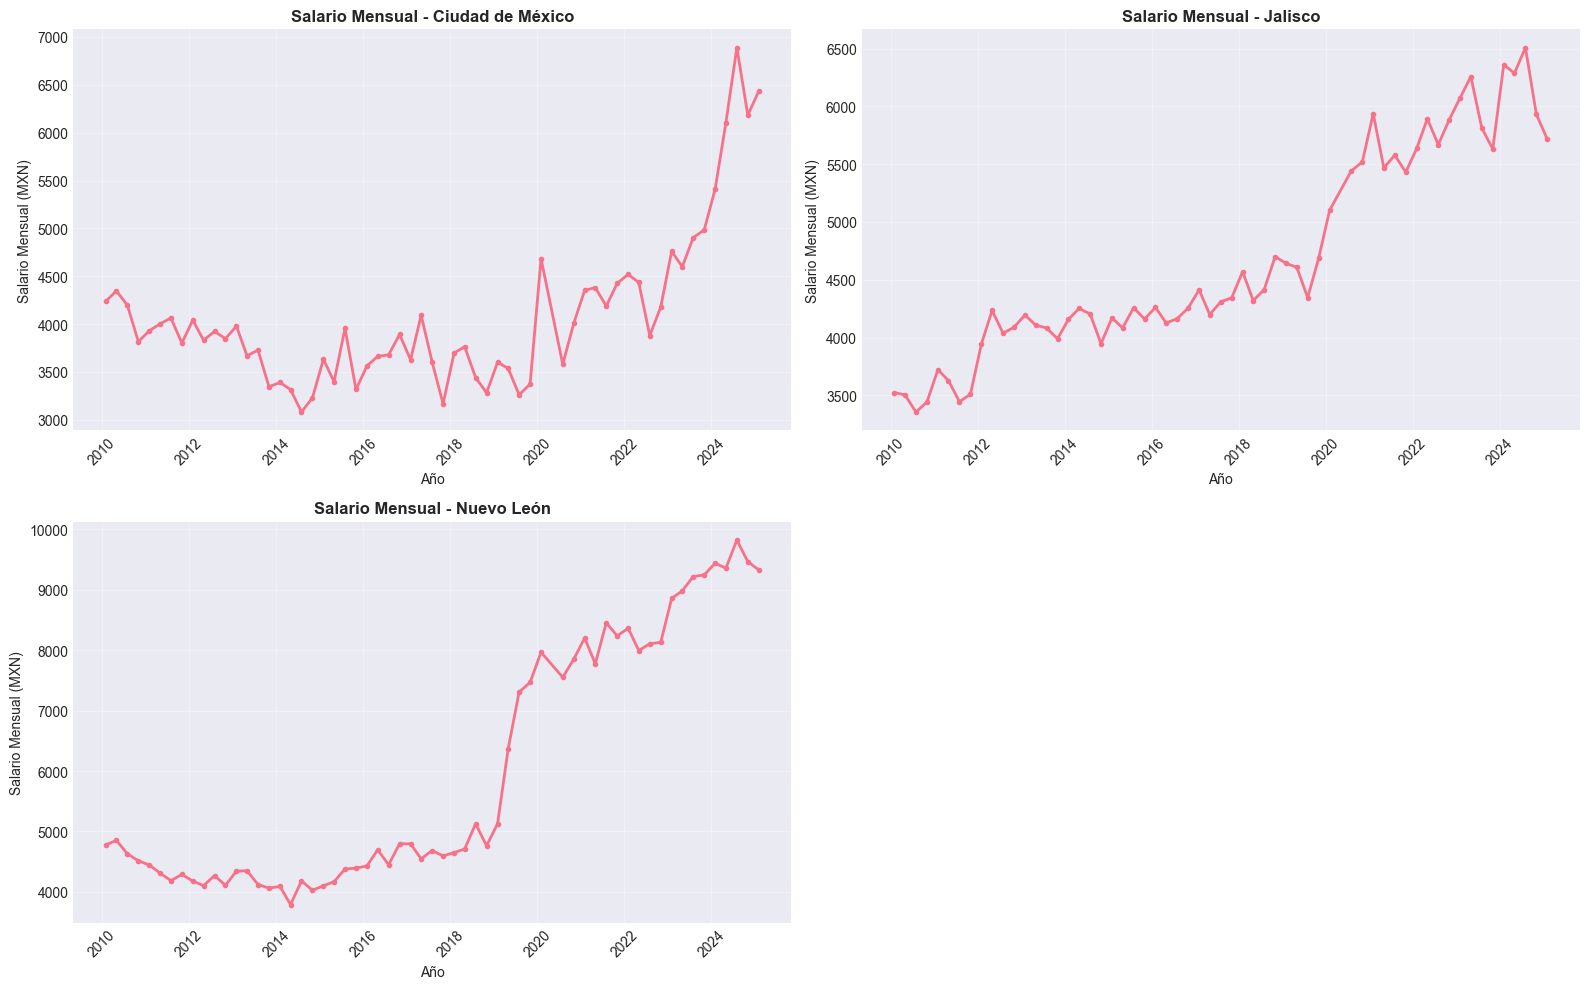

In [4]:
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

for estado, ax in zip(salarios['State'].unique(), axes.flat[:3]):
    data = salarios[salarios['State'] == estado]
    ax.plot(data['Date'], data['Monthly Wage'], linewidth=2, marker='o', markersize=3)
    ax.set_title(f'Salario Mensual - {estado}', fontsize=12, fontweight='bold')
    ax.set_xlabel('Año')
    ax.set_ylabel('Salario Mensual (MXN)')
    ax.grid(True, alpha=0.3)
    ax.tick_params(axis='x', rotation=45)

axes[1, 1].axis('off')
    
plt.tight_layout()
plt.savefig('evolucion_salarios.png', dpi=300, bbox_inches='tight')
plt.show()

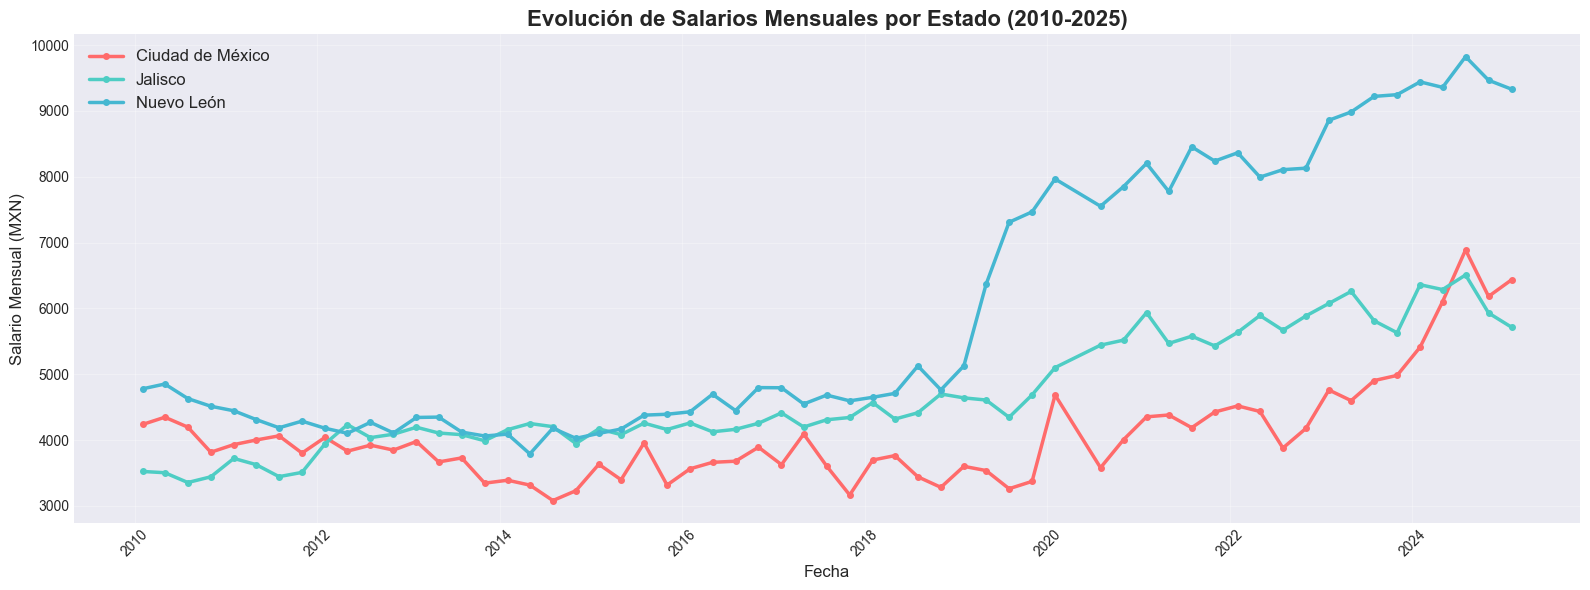

In [5]:
fig, ax = plt.subplots(figsize=(16, 6))
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']

for i, estado in enumerate(salarios['State'].unique()):
    data = salarios[salarios['State'] == estado]
    ax.plot(data['Date'], data['Monthly Wage'], linewidth=2.5, marker='o', markersize=4, label=estado, color=colors[i])

ax.set_title('Evolución de Salarios Mensuales por Estado (2010-2025)', fontsize=16, fontweight='bold')
ax.set_xlabel('Fecha', fontsize=12)
ax.set_ylabel('Salario Mensual (MXN)', fontsize=12)
ax.legend(fontsize=12)
ax.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 4. Análisis de Fuerza Laboral

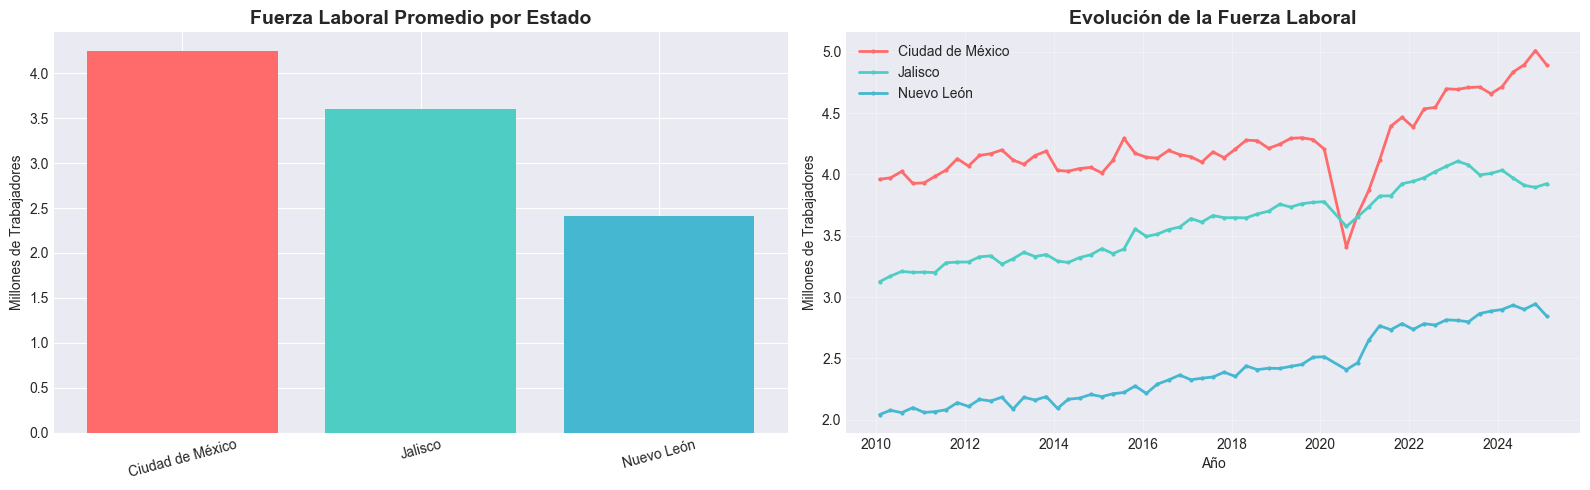

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

workforce_by_state = salarios.groupby('State')['Workforce'].mean().sort_values(ascending=False)
axes[0].bar(workforce_by_state.index, workforce_by_state.values / 1e6, color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
axes[0].set_title('Fuerza Laboral Promedio por Estado', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Millones de Trabajadores')
axes[0].tick_params(axis='x', rotation=15)

for i, estado in enumerate(salarios['State'].unique()):
    data = salarios[salarios['State'] == estado]
    axes[1].plot(data['Date'], data['Workforce'] / 1e6, linewidth=2, label=estado, marker='o', markersize=2, color=colors[i])

axes[1].set_title('Evolución de la Fuerza Laboral', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Año')
axes[1].set_ylabel('Millones de Trabajadores')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('fuerza_laboral.png', dpi=300, bbox_inches='tight')
plt.show()

## 5. Inversión Extranjera Directa

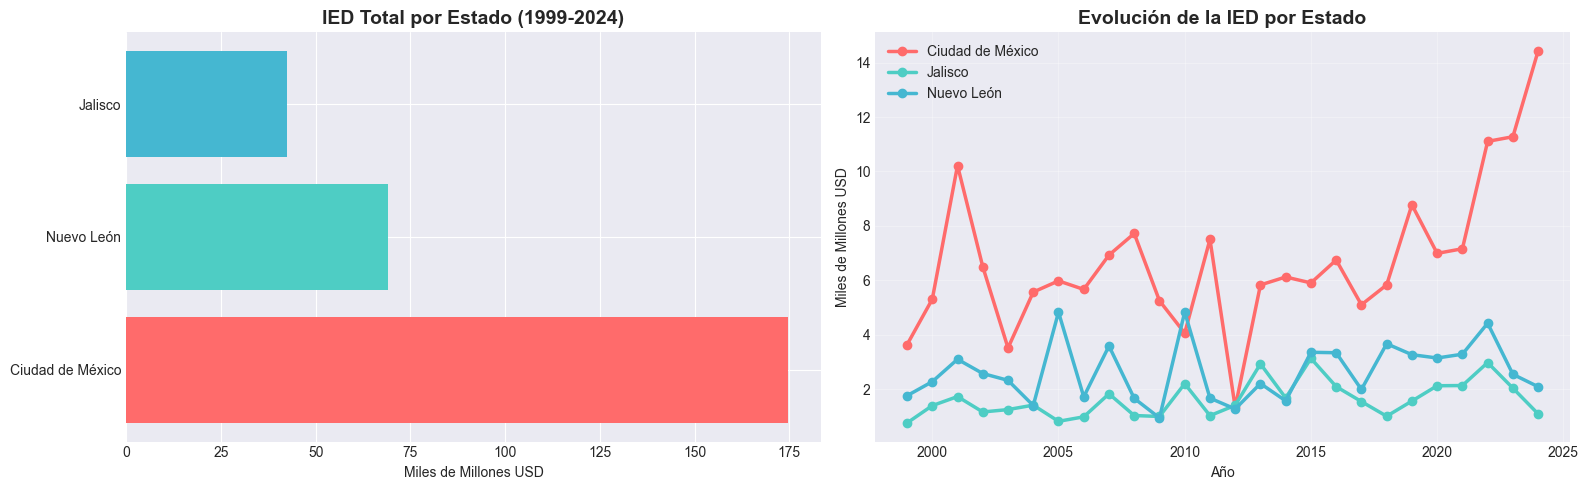

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

ied_total = ied.groupby('State')['Investment_B'].sum().sort_values(ascending=False)
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']
axes[0].barh(ied_total.index, ied_total.values, color=colors)
axes[0].set_title('IED Total por Estado (1999-2024)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Miles de Millones USD')

for i, estado in enumerate(ied['State'].unique()):
    data = ied[ied['State'] == estado]
    axes[1].plot(data['Year'], data['Investment_B'], linewidth=2.5, marker='o', markersize=6, label=estado, color=colors[i])

axes[1].set_title('Evolución de la IED por Estado', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Año')
axes[1].set_ylabel('Miles de Millones USD')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('ied_analisis.png', dpi=300, bbox_inches='tight')
plt.show()

## 6. Correlación: Salarios vs IED

In [8]:
salarios_anual = salarios.groupby(['State', 'Year']).agg({
    'Monthly Wage': 'mean',
    'Workforce': 'mean'
}).reset_index()

datos_completos = pd.merge(salarios_anual, ied[['State', 'Year', 'Investment_B']], 
                           on=['State', 'Year'], how='inner')

correlaciones = datos_completos.groupby('State').apply(
    lambda x: x[['Monthly Wage', 'Investment_B']].corr().iloc[0, 1]
)

print("\nCorrelación Salario-IED por Estado:")
for estado, corr in correlaciones.items():
    print(f"{estado}: {corr:.3f}")


Correlación Salario-IED por Estado:
Ciudad de México: 0.703
Jalisco: 0.052
Nuevo León: 0.203


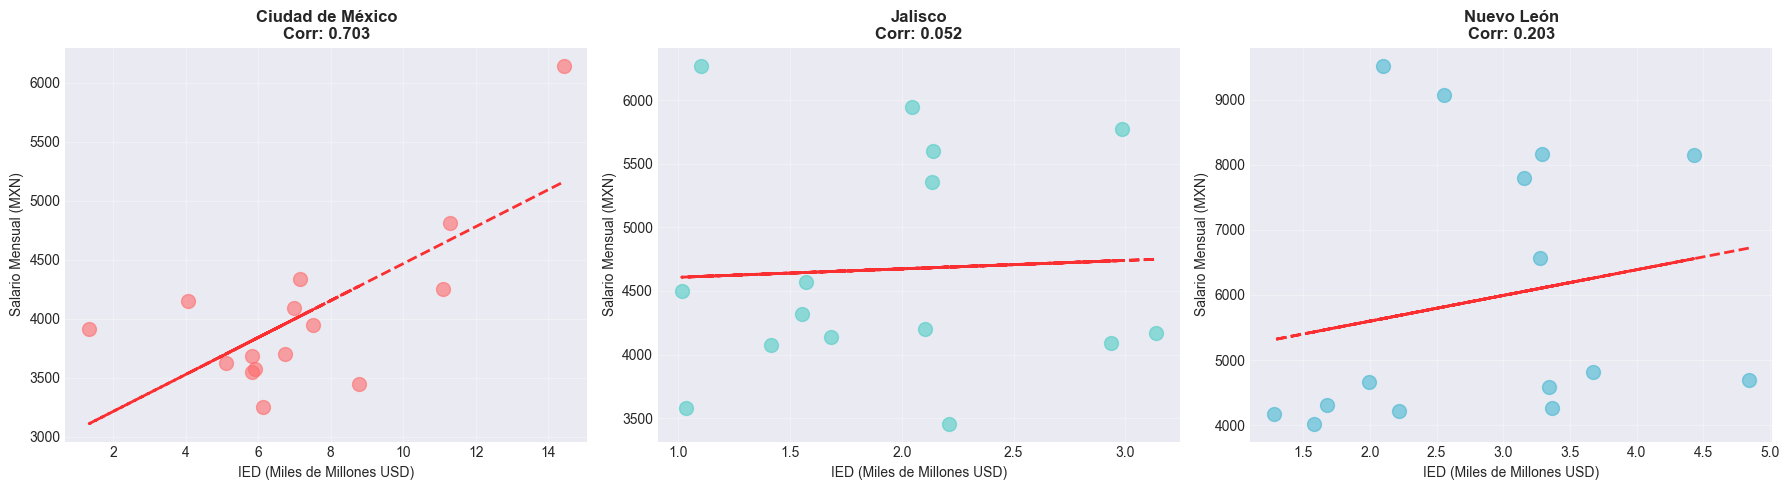

In [9]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, estado in enumerate(datos_completos['State'].unique()):
    data = datos_completos[datos_completos['State'] == estado]
    axes[i].scatter(data['Investment_B'], data['Monthly Wage'], s=100, alpha=0.6, color=colors[i])
    
    z = np.polyfit(data['Investment_B'], data['Monthly Wage'], 1)
    p = np.poly1d(z)
    axes[i].plot(data['Investment_B'], p(data['Investment_B']), "r--", linewidth=2, alpha=0.8)
    
    axes[i].set_title(f'{estado}\nCorr: {correlaciones[estado]:.3f}', fontsize=12, fontweight='bold')
    axes[i].set_xlabel('IED (Miles de Millones USD)')
    axes[i].set_ylabel('Salario Mensual (MXN)')
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('correlacion_salarios_ied.png', dpi=300, bbox_inches='tight')
plt.show()

## 7. Análisis de Tendencias y Crecimiento

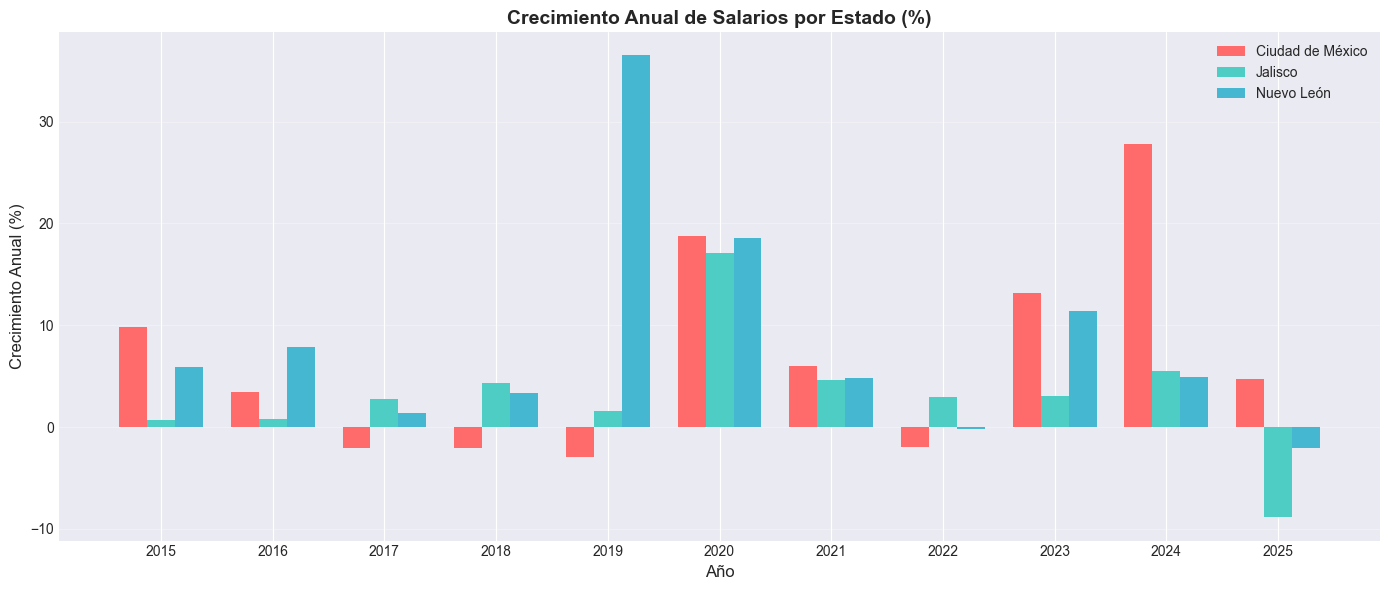

In [10]:
crecimiento_salarios = salarios.groupby(['State', 'Year'])['Monthly Wage'].mean().reset_index()
crecimiento_salarios['Crecimiento_%'] = crecimiento_salarios.groupby('State')['Monthly Wage'].pct_change() * 100

fig, ax = plt.subplots(figsize=(14, 6))
data_plot = crecimiento_salarios[crecimiento_salarios['Year'] >= 2015]

x = np.arange(len(data_plot['Year'].unique()))
width = 0.25
estados = data_plot['State'].unique()

for i, estado in enumerate(estados):
    data_estado = data_plot[data_plot['State'] == estado]
    ax.bar(x + i*width, data_estado['Crecimiento_%'], width, label=estado, color=colors[i])

ax.set_xlabel('Año', fontsize=12)
ax.set_ylabel('Crecimiento Anual (%)', fontsize=12)
ax.set_title('Crecimiento Anual de Salarios por Estado (%)', fontsize=14, fontweight='bold')
ax.set_xticks(x + width)
ax.set_xticklabels(data_plot['Year'].unique())
ax.legend()
ax.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

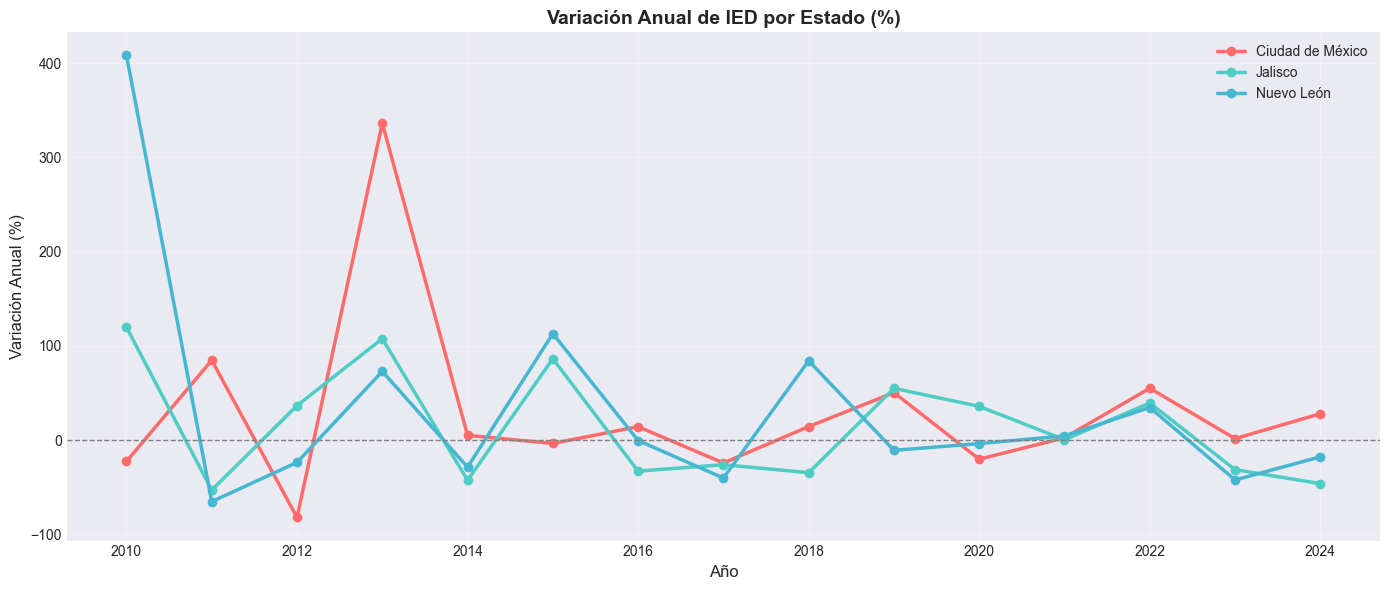

In [11]:
crecimiento_ied = ied.copy()
crecimiento_ied['Crecimiento_%'] = crecimiento_ied.groupby('State')['Investment_B'].pct_change() * 100

fig, ax = plt.subplots(figsize=(14, 6))
data_plot = crecimiento_ied[crecimiento_ied['Year'] >= 2010]

for i, estado in enumerate(data_plot['State'].unique()):
    data_estado = data_plot[data_plot['State'] == estado]
    ax.plot(data_estado['Year'], data_estado['Crecimiento_%'], linewidth=2.5, marker='o', markersize=6, label=estado, color=colors[i])

ax.axhline(y=0, color='gray', linestyle='--', linewidth=1)
ax.set_xlabel('Año', fontsize=12)
ax.set_ylabel('Variación Anual (%)', fontsize=12)
ax.set_title('Variación Anual de IED por Estado (%)', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 8. Modelo Predictivo: Regresión Lineal

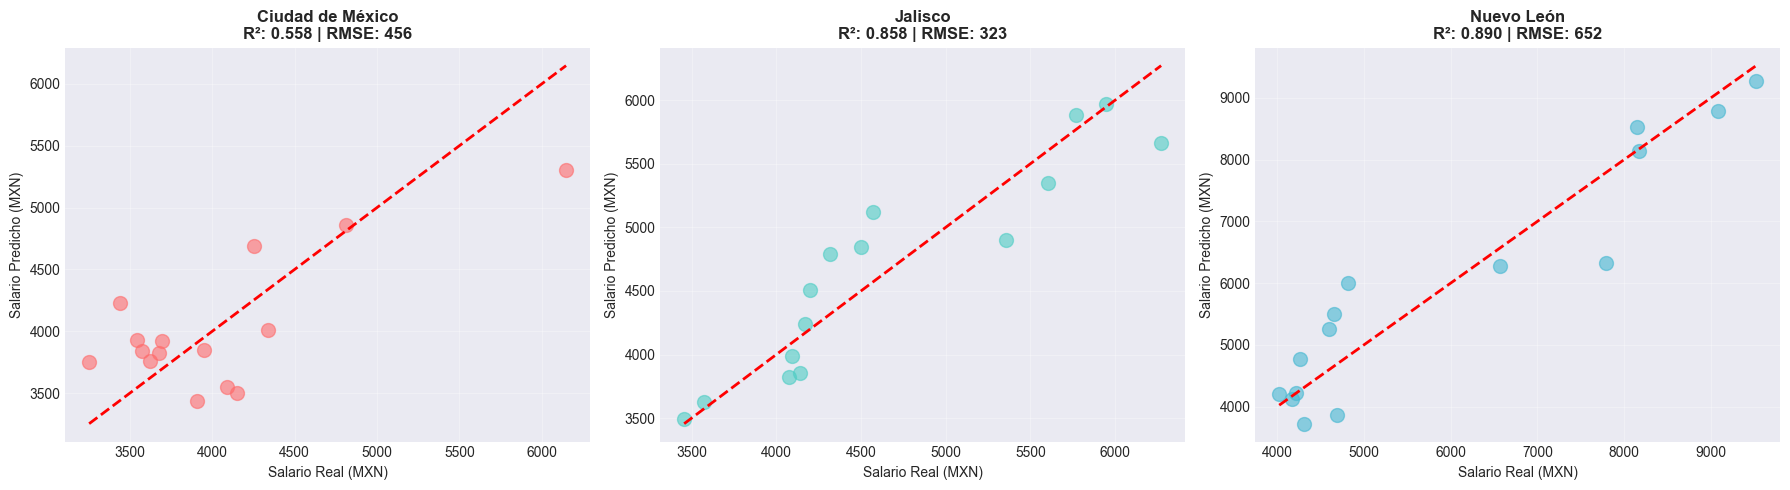


Resultados del Modelo por Estado:

Ciudad de México:
  R²: 0.5581
  RMSE: 455.9579
  Coef_IED: 271.1601
  Coef_Workforce: 273.1609

Jalisco:
  R²: 0.8580
  RMSE: 322.8074
  Coef_IED: 30.3519
  Coef_Workforce: 792.4890

Nuevo León:
  R²: 0.8898
  RMSE: 652.2014
  Coef_IED: 82.6407
  Coef_Workforce: 1837.3643


In [12]:
resultados_modelo = {}

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, estado in enumerate(datos_completos['State'].unique()):
    data = datos_completos[datos_completos['State'] == estado].copy()
    
    X = data[['Investment_B', 'Workforce']].values
    y = data['Monthly Wage'].values
    
    scaler_X = StandardScaler()
    X_scaled = scaler_X.fit_transform(X)
    
    modelo = LinearRegression()
    modelo.fit(X_scaled, y)
    y_pred = modelo.predict(X_scaled)
    
    r2 = r2_score(y, y_pred)
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    
    resultados_modelo[estado] = {
        'R²': r2,
        'RMSE': rmse,
        'Coef_IED': modelo.coef_[0],
        'Coef_Workforce': modelo.coef_[1]
    }
    
    axes[i].scatter(y, y_pred, alpha=0.6, s=100, color=colors[i])
    axes[i].plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
    axes[i].set_title(f'{estado}\nR²: {r2:.3f} | RMSE: {rmse:.0f}', fontsize=12, fontweight='bold')
    axes[i].set_xlabel('Salario Real (MXN)')
    axes[i].set_ylabel('Salario Predicho (MXN)')
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('modelo_predictivo.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nResultados del Modelo por Estado:")
for estado, metricas in resultados_modelo.items():
    print(f"\n{estado}:")
    for metrica, valor in metricas.items():
        print(f"  {metrica}: {valor:.4f}")

## 9. Dashboard Comparativo Final

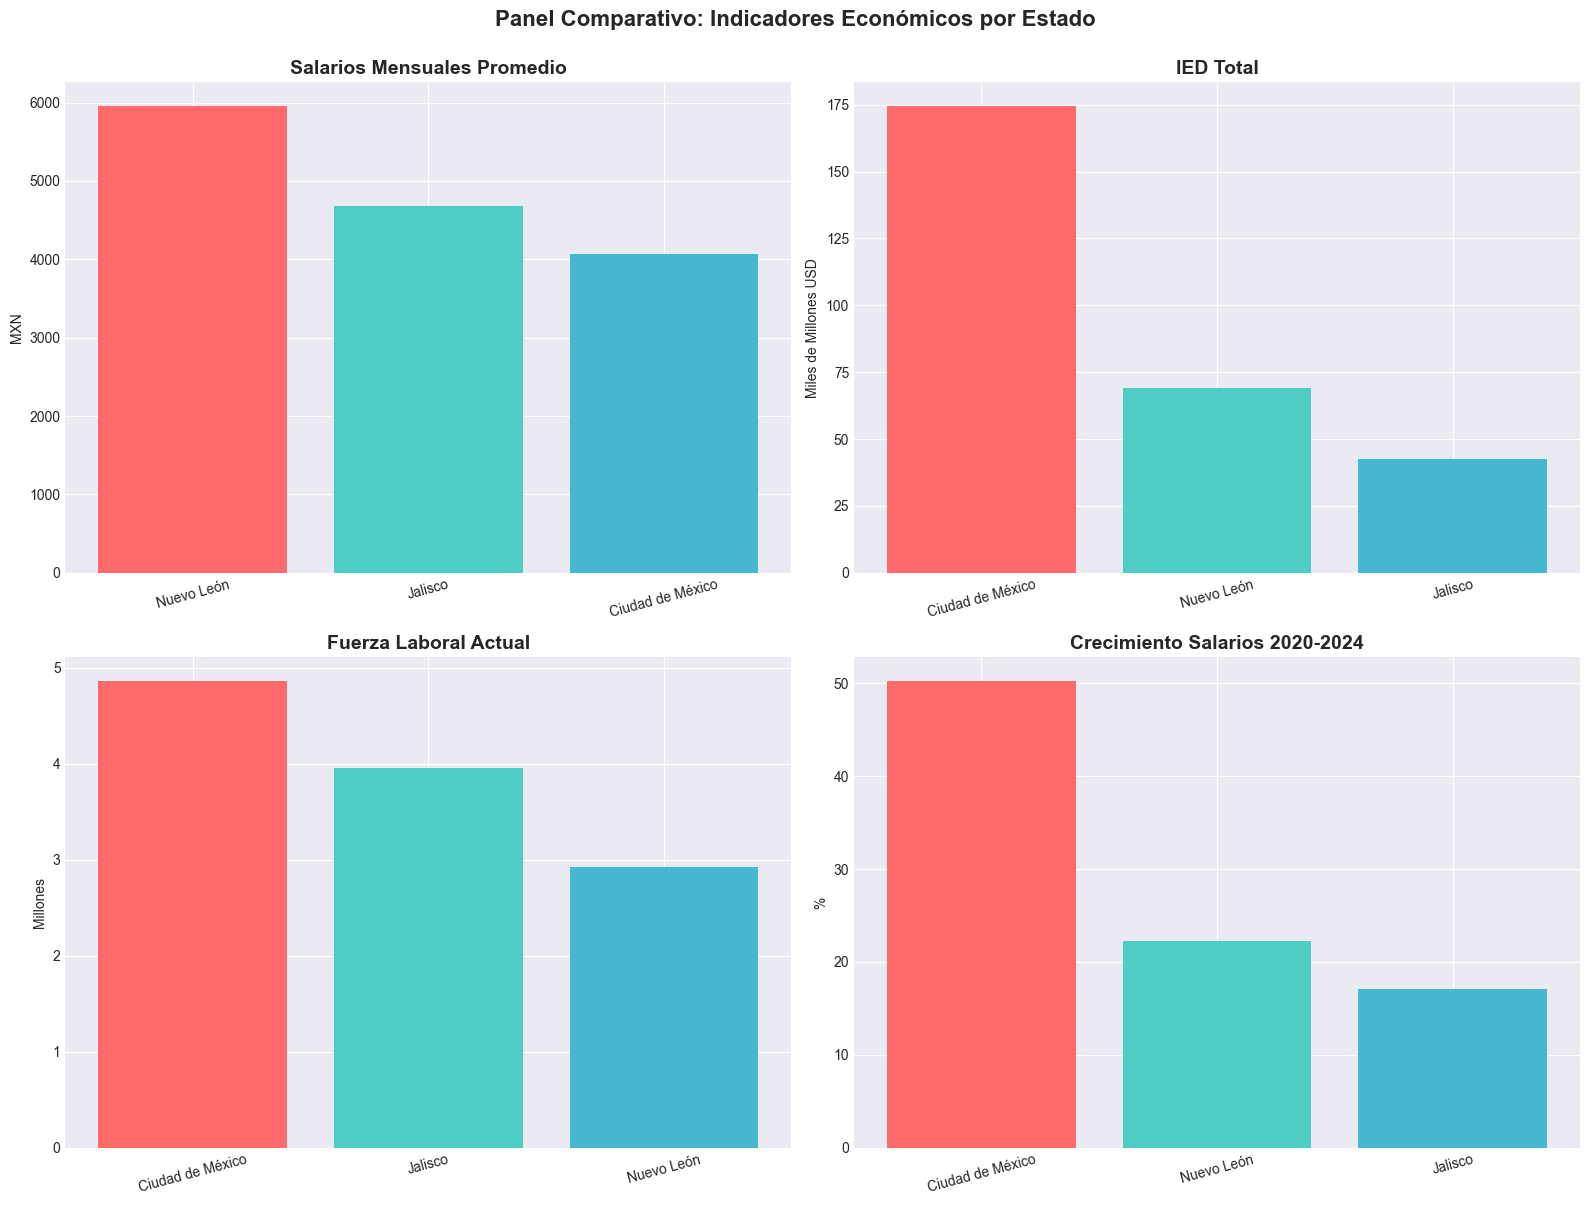

In [13]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

salarios_prom = salarios.groupby('State')['Monthly Wage'].mean().sort_values(ascending=False)
axes[0, 0].bar(salarios_prom.index, salarios_prom.values, color=colors)
axes[0, 0].set_title('Salarios Mensuales Promedio', fontsize=14, fontweight='bold')
axes[0, 0].set_ylabel('MXN')
axes[0, 0].tick_params(axis='x', rotation=15)

ied_total = ied.groupby('State')['Investment_B'].sum().sort_values(ascending=False)
axes[0, 1].bar(ied_total.index, ied_total.values, color=colors)
axes[0, 1].set_title('IED Total', fontsize=14, fontweight='bold')
axes[0, 1].set_ylabel('Miles de Millones USD')
axes[0, 1].tick_params(axis='x', rotation=15)

workforce_actual = salarios[salarios['Year'] == 2024].groupby('State')['Workforce'].mean() / 1e6
axes[1, 0].bar(workforce_actual.index, workforce_actual.values, color=colors)
axes[1, 0].set_title('Fuerza Laboral Actual', fontsize=14, fontweight='bold')
axes[1, 0].set_ylabel('Millones')
axes[1, 0].tick_params(axis='x', rotation=15)

sal_2020 = salarios[salarios['Year'] == 2020].groupby('State')['Monthly Wage'].mean()
sal_2024 = salarios[salarios['Year'] == 2024].groupby('State')['Monthly Wage'].mean()
crec = ((sal_2024 - sal_2020) / sal_2020 * 100).sort_values(ascending=False)
axes[1, 1].bar(crec.index, crec.values, color=colors)
axes[1, 1].set_title('Crecimiento Salarios 2020-2024', fontsize=14, fontweight='bold')
axes[1, 1].set_ylabel('%')
axes[1, 1].tick_params(axis='x', rotation=15)

fig.suptitle('Panel Comparativo: Indicadores Económicos por Estado', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.savefig('dashboard_comparativo.png', dpi=300, bbox_inches='tight')
plt.show()

## 10. Conclusiones

In [14]:
print("="*60)
print("RESUMEN EJECUTIVO")
print("="*60)

print("\n1. SALARIOS (Promedio 2010-2025):")
for estado in salarios['State'].unique():
    prom = salarios[salarios['State'] == estado]['Monthly Wage'].mean()
    print(f"   {estado}: ${prom:,.0f} MXN")

print("\n2. INVERSIÓN EXTRANJERA DIRECTA (Total 1999-2024):")
for estado in ied['State'].unique():
    total = ied[ied['State'] == estado]['Investment_B'].sum()
    print(f"   {estado}: ${total:.2f} Miles de Millones USD")

print("\n3. FUERZA LABORAL (Promedio):")
for estado in salarios['State'].unique():
    prom = salarios[salarios['State'] == estado]['Workforce'].mean() / 1e6
    print(f"   {estado}: {prom:.2f} Millones de trabajadores")

print("\n4. CORRELACIÓN SALARIOS-IED:")
for estado, corr in correlaciones.items():
    intensidad = "Fuerte" if abs(corr) > 0.7 else "Moderada" if abs(corr) > 0.4 else "Débil"
    print(f"   {estado}: {corr:.3f} ({intensidad})")

print("\n5. PRECISIÓN MODELO PREDICTIVO (R²):")
for estado, metricas in resultados_modelo.items():
    print(f"   {estado}: {metricas['R²']:.3f}")

print("\n" + "="*60)

RESUMEN EJECUTIVO

1. SALARIOS (Promedio 2010-2025):
   Ciudad de México: $4,070 MXN
   Jalisco: $4,675 MXN
   Nuevo León: $5,959 MXN

2. INVERSIÓN EXTRANJERA DIRECTA (Total 1999-2024):
   Ciudad de México: $174.55 Miles de Millones USD
   Jalisco: $42.53 Miles de Millones USD
   Nuevo León: $69.04 Miles de Millones USD

3. FUERZA LABORAL (Promedio):
   Ciudad de México: 4.24 Millones de trabajadores
   Jalisco: 3.60 Millones de trabajadores
   Nuevo León: 2.41 Millones de trabajadores

4. CORRELACIÓN SALARIOS-IED:
   Ciudad de México: 0.703 (Fuerte)
   Jalisco: 0.052 (Débil)
   Nuevo León: 0.203 (Débil)

5. PRECISIÓN MODELO PREDICTIVO (R²):
   Ciudad de México: 0.558
   Jalisco: 0.858
   Nuevo León: 0.890

